In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:35<00:00, 20.6MB/s]
100% 1.76G/1.76G [01:35<00:00, 19.9MB/s]


In [ ]:
! unzip '/content/lung-and-colon-cancer-histopathological-images.zip' -d '/content/lung-and-colon-cancer-histopathological-images'

In [6]:
datadir='/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [9]:
transform = T.Compose([T.Resize([224,224]), T.ToTensor()])

In [10]:
dataset=datasets.ImageFolder(datadir,transform=transform)

In [11]:
len(dataset)

15000

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [12500, 2500])

In [53]:
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [54]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 3, 224, 224])


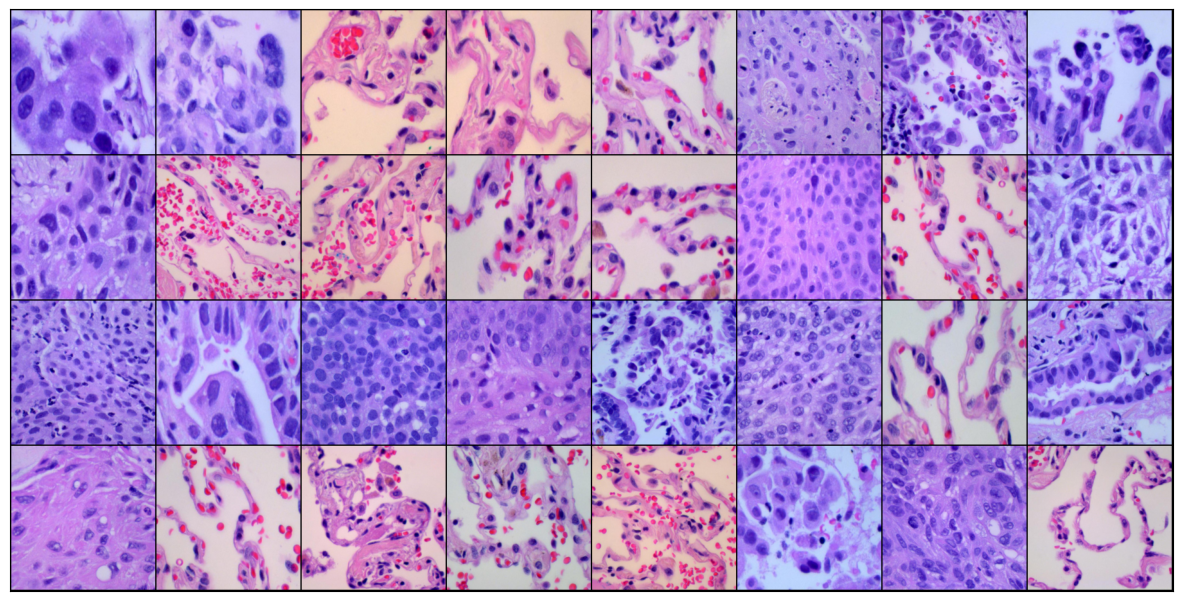

In [55]:
show_batch(train_loader)

In [ ]:
import torchvision.models as models
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
model.to(device);

In [57]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [59]:
model.classifier[1] = nn.Linear(1280, 3)

In [60]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [61]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=torch.tensor([3.0,1.0,3.0]).to(device)) # выставляем веса, т.к. стоимость классов неравноценна (рак>доброкачественной)

In [62]:
!pip install pytorch-ignite --quiet

In [63]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [64]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [65]:
metrics = { "loss" : Loss(criterion), 
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=3)}

In [66]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [67]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [68]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [69]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [70]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [71]:
import shutil
shutil.rmtree('./models')

In [72]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [73]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [74]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  1%|1         | 1/98 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 99.58 Сред. ошибка: 0.01549
Результат валидации - Эпоха: 1  Сред. точность: 99.60 Сред. ошибка: 0.01701


  1%|1         | 1/98 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 99.86 Сред. ошибка: 0.00501
Результат валидации - Эпоха: 2  Сред. точность: 99.80 Сред. ошибка: 0.00837


  1%|1         | 1/98 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 99.79 Сред. ошибка: 0.00917
Результат валидации - Эпоха: 3  Сред. точность: 99.40 Сред. ошибка: 0.02255


  1%|1         | 1/98 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 100.00 Сред. ошибка: 0.00024
Результат валидации - Эпоха: 4  Сред. точность: 100.00 Сред. ошибка: 0.00023


  1%|1         | 1/98 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 99.90 Сред. ошибка: 0.00317
Результат валидации - Эпоха: 5  Сред. точность: 99.64 Сред. ошибка: 0.00728


State:
	iteration: 490
	epoch: 5
	epoch_length: 98
	max_epochs: 5
	output: 0.04143482446670532
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

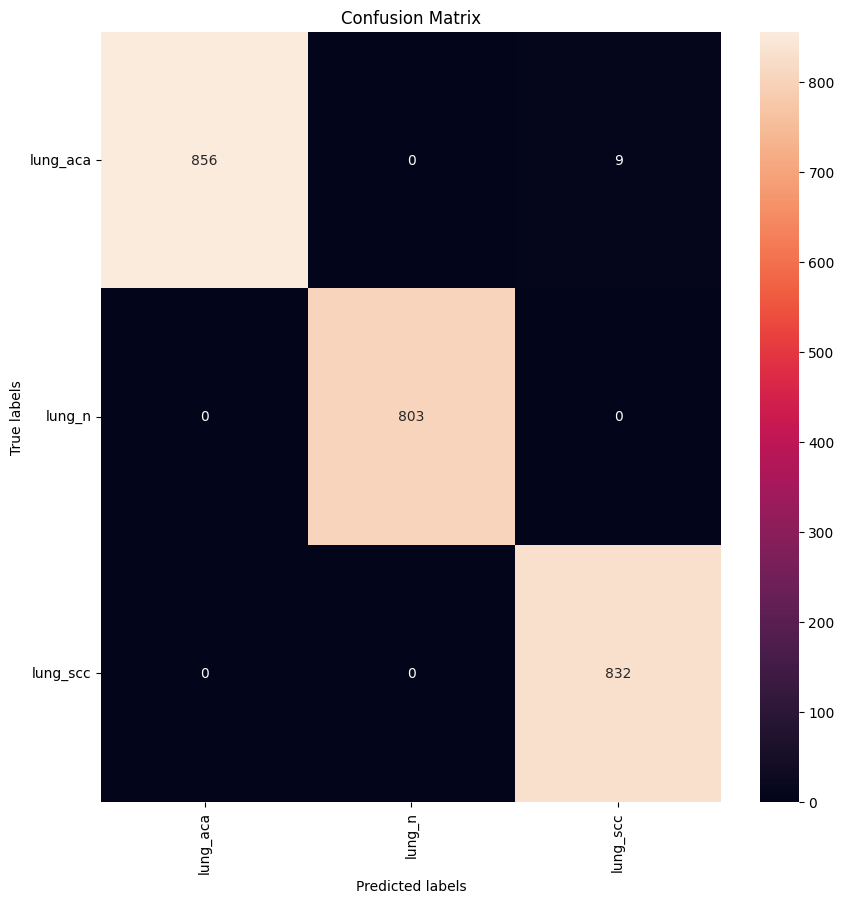

In [75]:
trainer.run(train_loader, max_epochs=5)

In [76]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [77]:
def get_preds(model, loader, device):
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)

  with torch.no_grad():
      for data in test_loader:
          inputs = [i.to(device) for i in data[:-1]]
          labels = data[-1].to(device)
          
          outputs = model(*inputs)
          y_true = torch.cat((y_true, labels), 0)
          all_outputs = torch.cat((all_outputs, outputs), 0)
    
      y_true = y_true.cpu().numpy()  
      _, y_pred = torch.max(all_outputs, 1)
      y_pred = y_pred.cpu().numpy()
      y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
  return y_true, y_pred, y_pred_prob

In [78]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [89]:
from sklearn.metrics import matthews_corrcoef, classification_report

In [90]:
print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       865
      lung_n       1.00      1.00      1.00       803
    lung_scc       1.00      1.00      1.00       832

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [91]:
matthews_corrcoef(y_true,y_pred)

1.0

In [92]:
from PIL import Image
img=Image.open('/content/squamous-cell-carcinoma-lung.jpg')
tr=T.Compose([T.Resize([224,224]),T.ToTensor()])
tensor=tr(img)
tensor = tensor.to(device)
tensor = tensor.unsqueeze_(0)
model.eval()
output=model(tensor)

In [94]:
F.softmax(output.to('cpu'), dim=1)

tensor([[0.0337, 0.0196, 0.9467]], grad_fn=<SoftmaxBackward0>)